Let's import all needed libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [4]:
def load_dataset():
    url = "googleplaystore.csv"  # Replace "URL" with the actual URL or local file path of the dataset
    dataset = pd.read_csv(url)
    return dataset

play = load_dataset()

play

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53M,"5,000+",Free,0,Everyone,Education,"July 25, 2017",1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6M,100+,Free,0,Everyone,Education,"July 6, 2018",1.0,4.1 and up
10838,Parkinson Exercices FR,MEDICAL,NaN,3,9.5M,"1,000+",Free,0,Everyone,Medical,"January 20, 2017",1.0,2.2 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,Varies with device,"1,000+",Free,0,Mature 17+,Books & Reference,"January 19, 2015",Varies with device,Varies with device


In [5]:
def print_summarize_dataset(dataset):
    print("Dataset dimension:")
    print(dataset.shape)
    print("\nFirst 10 rows of dataset:")
    print(dataset.head(10))
    print("\nStatistical summary:")
    print(dataset.describe())
    
    
summ = print_summarize_dataset(play)
summ

Dataset dimension:
(10841, 13)

First 10 rows of dataset:
                                                 App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   
5                         Paper flowers instructions  ART_AND_DESIGN     4.4   
6            Smoke Effect Photo Maker - Smoke Editor  ART_AND_DESIGN     3.8   
7                                   Infinite Painter  ART_AND_DESIGN     4.1   
8                               Garden Coloring Book  ART_AND_DESIGN     4.4   
9                      Kids Paint Free - Drawing Fun  ART_AND_DESIGN     4.7   

  Reviews  Size     Installs  Type Price Content Rating  \
0 

In [6]:
# 3. Clean the dataset
def clean_dataset(dataset):
    # Make a copy of the dataset to avoid modifying the original one
    dataset = dataset.copy()
    
    # Drop rows with missing values
    dataset = dataset.dropna()
    
    # Convert 'Reviews' column to numeric
    dataset['Reviews'] = pd.to_numeric(dataset['Reviews'])
    
    # Replace 'Varies with device' in 'Size' with NaN
    dataset['Size'] = dataset['Size'].replace('Varies with device', pd.NA)
    
    # Convert size units to numeric
    dataset['Size'] = dataset['Size'].str.replace('M', 'e6').str.replace('k', 'e3')
    dataset['Size'] = pd.to_numeric(dataset['Size'], errors='coerce')
    
    # Fill missing values in 'Size' with mean
    dataset['Size'] = dataset['Size'].fillna(dataset['Size'].mean())
    
    # Clean 'Installs' column
    dataset['Installs'] = dataset['Installs'].str.replace(',', '').str.replace('+', '')
    dataset['Installs'] = dataset['Installs'].astype('int64')
    
    # Clean 'Price' column
    dataset['Price'] = dataset['Price'].str.replace('$', '')
    dataset['Price'] = dataset['Price'].astype('float64')
    
    return dataset

cleaned_play = clean_dataset(play)
cleaned_play

/var/folders/6r/7sqtcdsd1hn2br6bn4n5fzc00000gn/T/ipykernel_89825/760301221.py:23: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dataset['Installs'] = dataset['Installs'].str.replace(',', '').str.replace('+', '')
/var/folders/6r/7sqtcdsd1hn2br6bn4n5fzc00000gn/T/ipykernel_89825/760301221.py:27: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dataset['Price'] = dataset['Price'].str.replace('$', '')


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,1.900000e+07,10000,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,1.400000e+07,500000,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.700000e+06,5000000,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,2.500000e+07,50000000,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.800000e+06,100000,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10834,FR Calculator,FAMILY,4.0,7,2.600000e+06,500,Free,0.0,Everyone,Education,"June 18, 2017",1.0.0,4.1 and up
10836,Sya9a Maroc - FR,FAMILY,4.5,38,5.300000e+07,5000,Free,0.0,Everyone,Education,"July 25, 2017",1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.600000e+06,100,Free,0.0,Everyone,Education,"July 6, 2018",1.0,4.1 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,2.297046e+07,1000,Free,0.0,Mature 17+,Books & Reference,"January 19, 2015",Varies with device,Varies with device


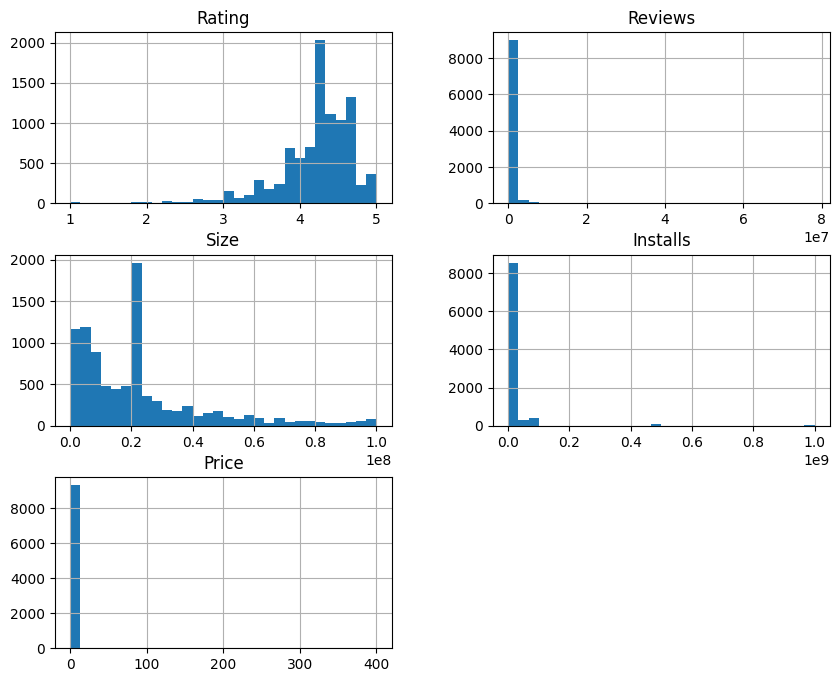

In [7]:
def print_histograms(boston_dataframe):
    boston_dataframe.hist(bins=30, figsize=(10,8))
    plt.show()

hist = print_histograms(cleaned_play)
hist

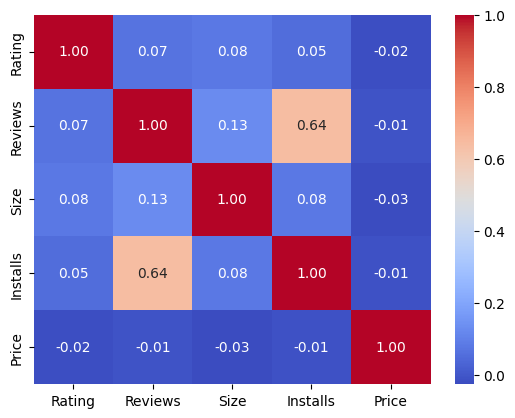

In [8]:
def compute_correlations_matrix(dataframe):
    # Exclude non-numeric columns before computing correlations
    numeric_df = dataframe.select_dtypes(include=['number'])
    
    # Compute the correlation matrix
    correlations = numeric_df.corr()
    
    # Plot the correlation matrix as a heatmap
    sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
    plt.show()

# Call the function with the cleaned DataFrame
compute_correlations_matrix(cleaned_play)

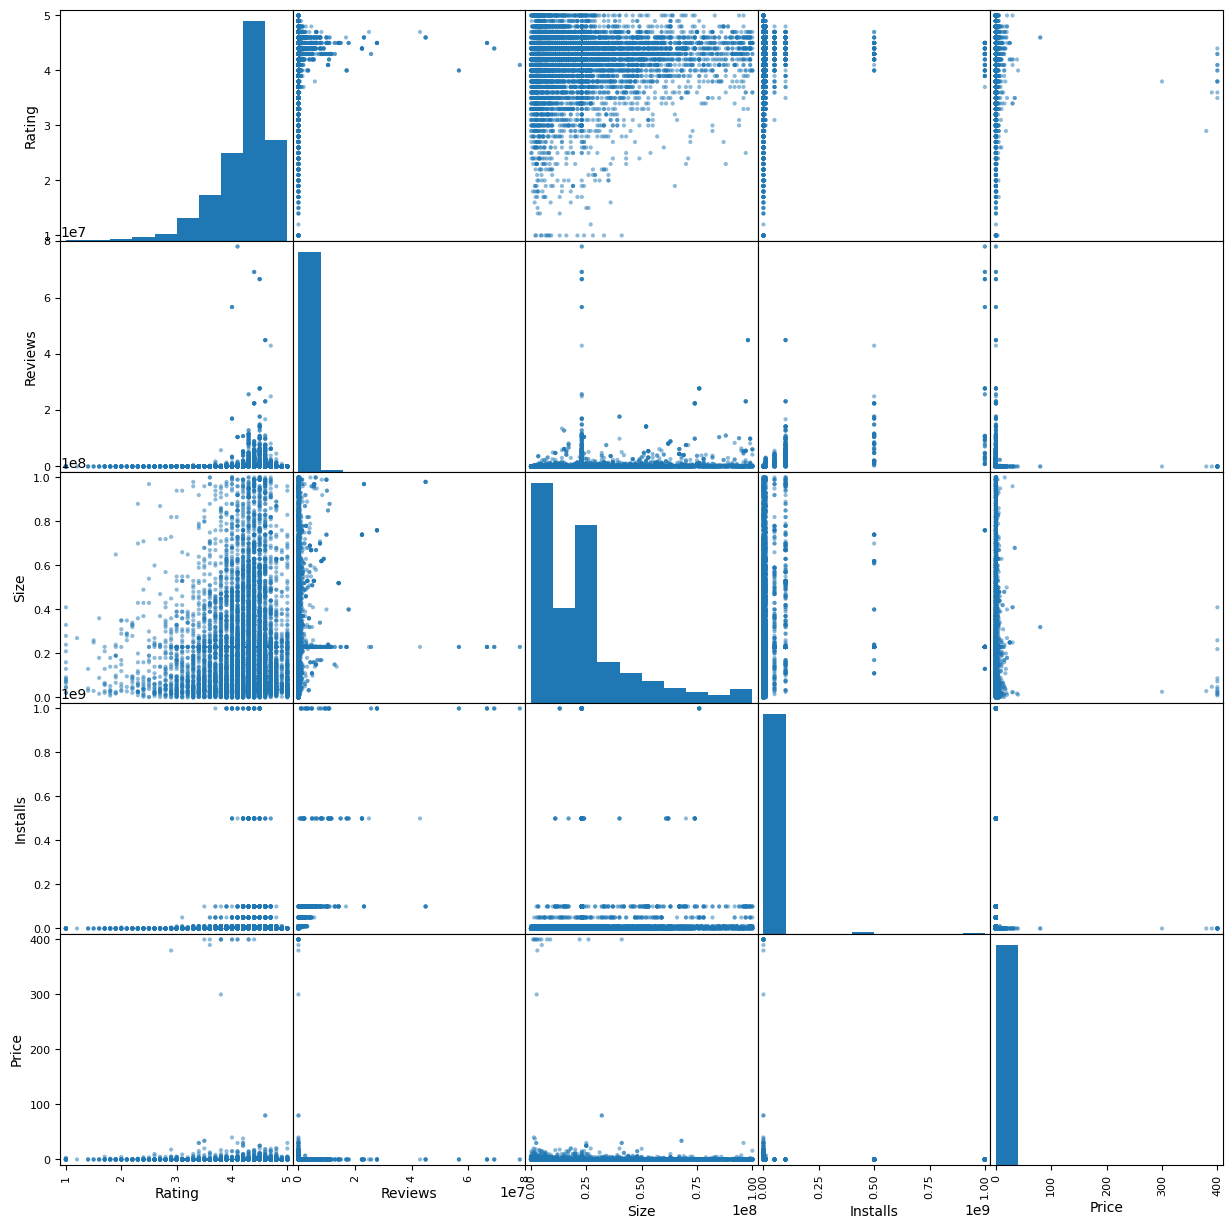

In [9]:
def print_scatter_matrix(dataframe):
    pd.plotting.scatter_matrix(dataframe, figsize=(15, 15))
    plt.show()


scatter = print_scatter_matrix(cleaned_play)
scatter

Exploratory Data Analysis (EDA):

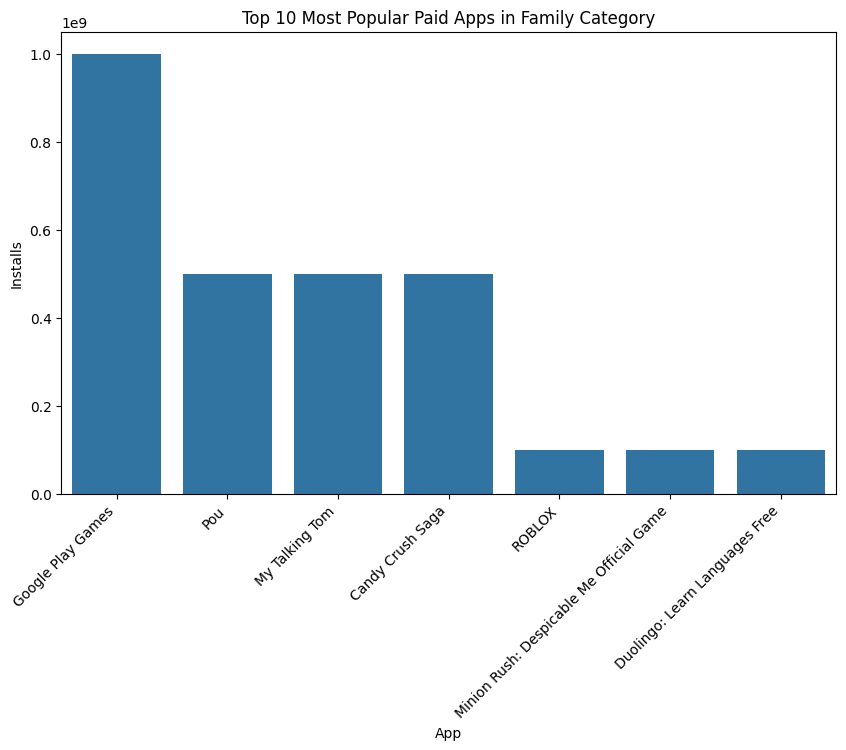

In [10]:
# Plot bar diagram of most popular paid apps in the Family category
family_apps = cleaned_play[cleaned_play['Category'] == 'FAMILY'].nlargest(10, 'Installs')
plt.figure(figsize=(10, 6))
sns.barplot(x='App', y='Installs', data=family_apps)
plt.title('Top 10 Most Popular Paid Apps in Family Category')
plt.xticks(rotation=45, ha='right')
plt.show()

Genre Distribution:

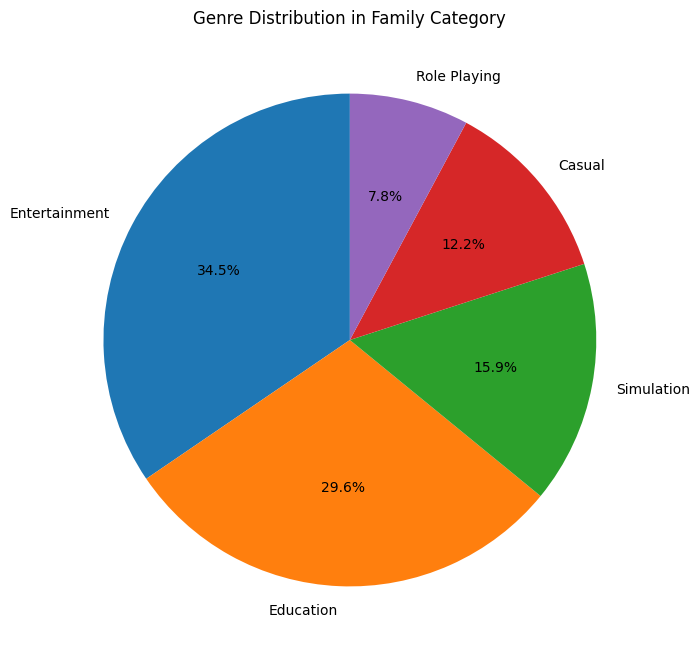

In [11]:
genre_counts = cleaned_play[cleaned_play['Category'] == 'FAMILY']['Genres'].value_counts().nlargest(5)
plt.figure(figsize=(8, 8))
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Genre Distribution in Family Category')
plt.show()

Installations per Category and Plot Pie Chart of Installations per Category:

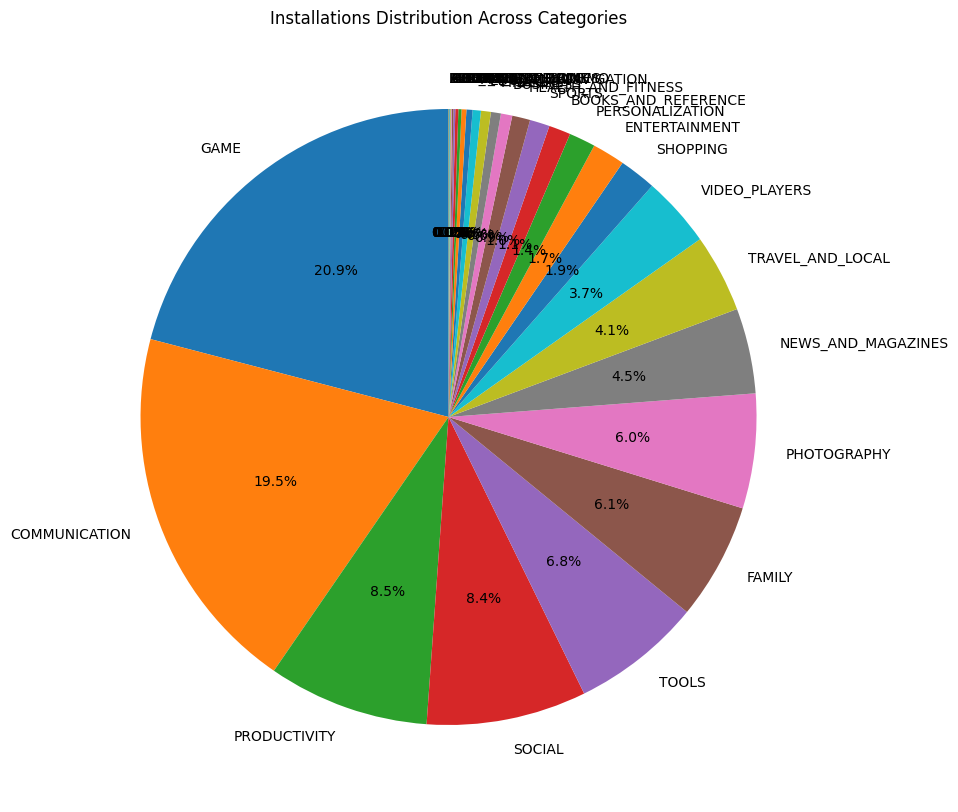

In [12]:
installations_per_category = cleaned_play.groupby('Category')['Installs'].sum().sort_values(ascending=False).reset_index()
plt.figure(figsize=(10, 10))
plt.pie(installations_per_category['Installs'], labels=installations_per_category['Category'], autopct='%1.1f%%', startangle=90)
plt.title('Installations Distribution Across Categories')
plt.show()

Mean Price per Category:

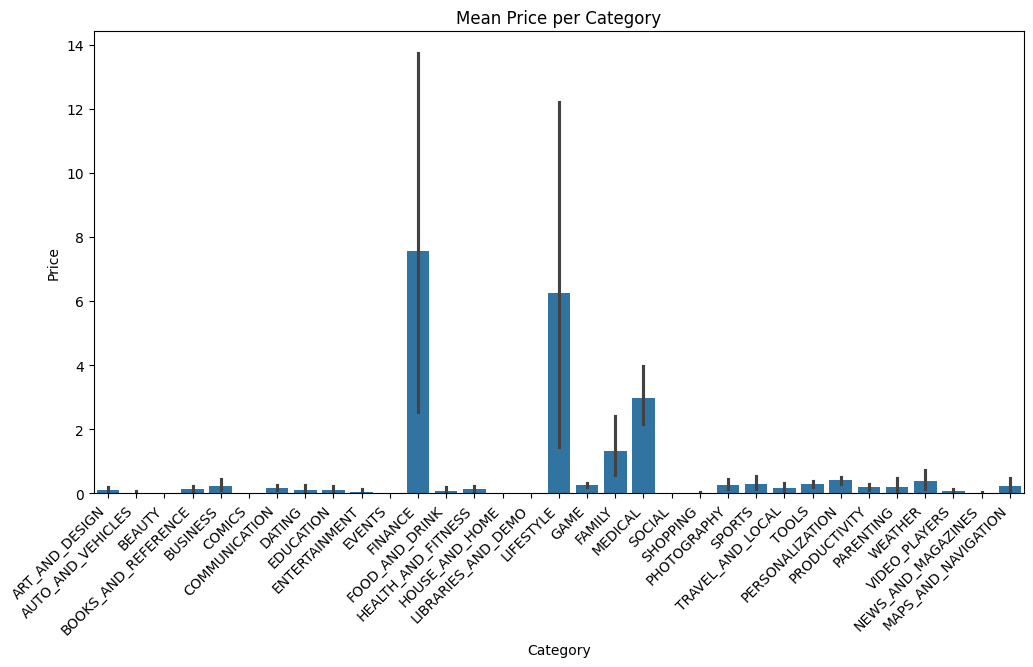

In [13]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Category', y='Price', data=cleaned_play, estimator=np.mean)
plt.title('Mean Price per Category')
plt.xticks(rotation=45, ha='right')
plt.show()

Most Expensive Apps per Category:

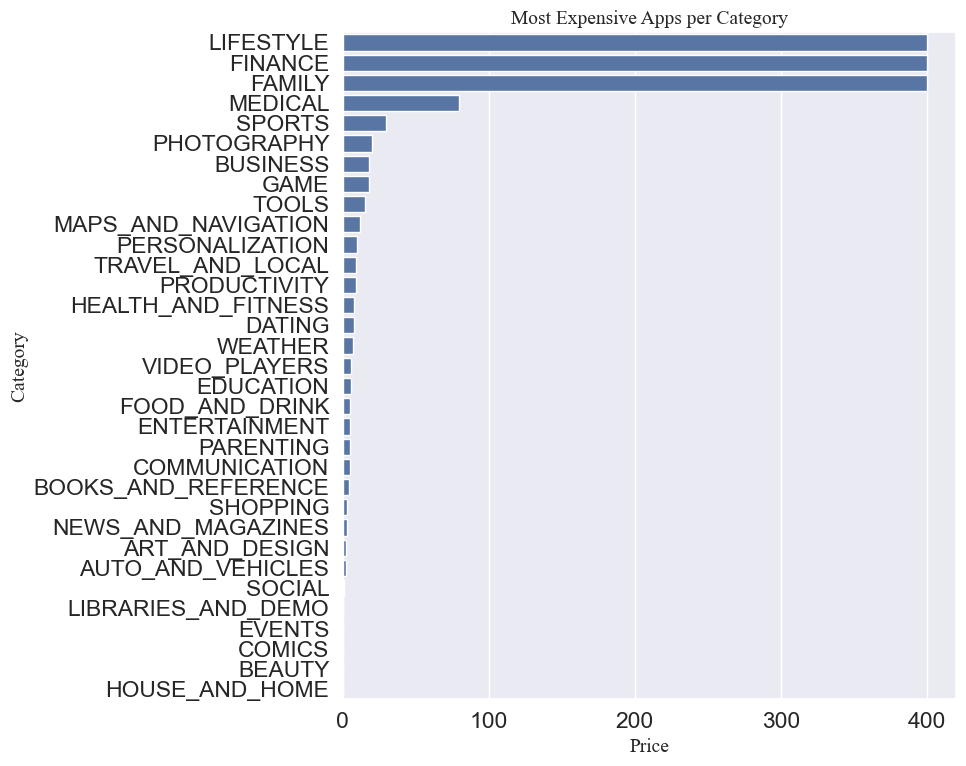

In [14]:
# Define the font family and size
font = {'family': 'serif', 'weight': 'normal', 'size': 14}
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']

# Group the DataFrame by 'Category' and find the most expensive app within each category
most_expensive_apps = cleaned_play.groupby('Category').apply(lambda x: x.loc[x['Price'].idxmax()]).reset_index(drop=True)

# Select only the necessary columns: 'Category', 'App', and 'Price'
most_expensive_apps = most_expensive_apps[['Category', 'App', 'Price']]

# Set the Seaborn style and font scale
sns.set_style("whitegrid")
sns.set(font_scale=1.5)

# Create a barplot using Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x='Price', y='Category', data=most_expensive_apps.sort_values('Price', ascending=False))
plt.xlabel('Price', fontdict=font)  # Set font for x-axis label
plt.ylabel('Category', fontdict=font)  # Set font for y-axis label
plt.title('Most Expensive Apps per Category', fontdict=font)  # Set font for title
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Conclusion:
In this analysis, we explored the most popular paid family apps, examined genre distributions, analyzed installations per category, visualized mean prices across categories, and identified the most expensive apps in each category.
From these visualizations we can see the following:
* The most expensive categories are Lifestyle, Family, and Finance.
* Lifestyle apps have the highest prices on average, followed by Family and Finance apps.
* These categories might include premium or specialized applications that offer unique features or services, which justify their higher prices.
* Users interested in apps within these categories should be prepared to invest more in acquiring them, potentially indicating a higher perceived value or demand for certain functionalities.
* Developers targeting these categories may find opportunities to create high-value, premium apps that cater to specific user needs and preferences within these segments.